In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.ascii 
import astropy.units as u
import astropy.constants as ac
import math as m

In [ ]:
# My custom plot specifiers
myplot_specs = {
 'axes.linewidth':  1.5, 
 'xtick.top' : True,         
 'ytick.right' :  True,
 'xtick.direction' : 'in',    
 'ytick.direction' : 'in', 
 'xtick.major.size' : 11,     
 'ytick.major.size' : 11,
 'xtick.minor.size' : 5.5,    
 'ytick.minor.size' : 5.5,      
 'font.size' : 18,              
 'figure.figsize' : [5.5, 5.5], 
 'lines.linewidth' : 2.5      
}
plt.rcParams.update(myplot_specs)

# Work on the Detection Signals of a Jupiter-like planet around a Sun-like star

Define parameters of the Jupiter-like planet and the Sun-like star

In [ ]:
#Planet mass, radius, semimajor axis
M_J = 1 * u.jupiterMass
R_J = 1 * u.jupiterRad
a_J = 5.2029 * u.AU
#Mass of the star
M_sun = 1 * u.solMass

## Radial Velocity

I will assume planet on a circular orbit, and we are viewing it exactly edge on ($i=90^{o}$).

Calculate the period of the planet using Kepler's Third Law
$$
P = 2\pi \sqrt{\frac{a_J^3}{G M_{\odot}}}
$$

In [ ]:
calc_p = (2*np.pi*np.sqrt(a_J**3/ac.G/M_sun)).decompose().to(u.year)
print("Period of the planet: P =", calc_p)

Period of the planet: P = 11.867969473205504 yr


Calculate the amplitude of the radial velocity signal (equation in the Week 2 PowerPoint)
$$
K = \frac{M_J}{M_{\odot}} \sqrt{\frac{G M_{\odot}}{a_J}}
$$

In [ ]:
K = (M_J/M_sun)*np.sqrt(ac.G*M_sun/a_J)
K_real = K.decompose()
print("RV amplitude: K =", K_real)

RV amplitude: K = 12.464910896128023 m / s


Make a plot of the RV signal. I added some Gaussian Noise to the plot to make it look like a simulated signal. The size of the noise corresponds with the state-of-the-art RV $(0.5 \frac{m}{s})$.

In [ ]:
phi = np.linspace(0, 1, 150)
RV_true = K_real*np.sin(phi*(2*np.pi))
RV_sim = RV_true + np.random.normal(0, 0.5, 150)*(u.m/u.s)
yerr = [0.5 for i in phi]

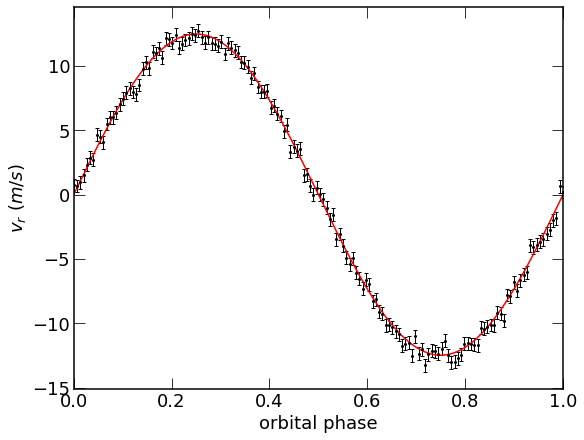

In [ ]:
fig, ax = plt.subplots(figsize=(8,6), constrained_layout=True)
ax.errorbar(phi, RV_sim.value, yerr=yerr, color='k', fmt='.', markersize=4, elinewidth=1, capsize=2)
ax.plot(phi, RV_true.value, 'r', linewidth=1.5)
ax.set_ylabel("$v_r$ ($m/s$)")
ax.set_xlabel("orbital phase")
ax.set_xlim(phi[0], phi[-1])
#fig.savefig("RV-signal-plot.jpg")
plt.show()

## Transit

Again, I assume circular orbit and edge-on. The transit depth is proportional to the square of the ratio of the radii.
$$
f = \left( \frac{R_J}{R_{\odot}} \right)^2
$$

In [ ]:
#transit depth
f = (R_J.decompose()/ac.R_sun)**2
print("Transit depth =", f)

Transit depth = 0.010560169441850946


The transit duration is the time it takes for the planet to cross the star.
$$
t = \frac{2 R_{\odot}}{v_J}
$$
I calculate the velocity assuming a circular orbit.
$$
v_J = \sqrt{ \frac{G M_{\odot}}{a_J} }
$$

In [ ]:
#velocity of Jupiter
v_J = np.sqrt(ac.G*M_sun/a_J)
#transit duration
t_transit = (2*ac.R_sun/v_J).decompose().to(u.hr)
print("Transit duration =", t_transit)

Transit duration = 29.59914230463945 h


The rest of this code is used to make the plot.

In [ ]:
#The x coordinates where the planet enters ingress and egress, respectively
inx1 = - ac.R_sun - R_J.decompose()
inx2 = ac.R_sun - R_J.decompose()

In [ ]:
#the x-coordinates where the planet exits ingress and egress, respectively
outx1 = - ac.R_sun + R_J.decompose()
outx2 = ac.R_sun + R_J.decompose()

In [ ]:
#find the times the planet enters and exits ingress
t_in1 = (inx1/v_J).decompose().to(u.hr)
t_out1 = (outx1/v_J).decompose().to(u.hr)
#find the times the planet enters and exits egress
t_in2 = (inx2/v_J).decompose().to(u.hr)
t_out2 = (outx2/v_J).decompose().to(u.hr)

In [ ]:
#define time domains where the planet is in ingress and egress, with a "measurement" every 0.1 hours
t_ingress = np.linspace(t_in1, t_out1, int((t_out1.value-t_in1.value)/0.1))
t_egress = np.linspace(t_in2, t_out2, int((t_out2.value-t_in2.value)/0.1))

In [ ]:
#during egress, find the fraction of the planet that is in front of the star
frac_here = []
rj = R_J.decompose().to(u.m)
for t in t_egress:
    #position of the center of the planet
    xn = ((v_J * t) - ac.R_sun) / R_J
    x = round(xn.decompose().value, 7)
    #assume the edge of the star is a straight, vertical line
    #fraction of the planet inside the star from geometry
    f_here = (np.arccos(x) - (1/2)*np.sin(2*np.arccos(x)))/np.pi
    frac_here.append(f_here)
#with the out of transit flux normalized to one and the in-transit flux is 1-f (from above), give the flux
egress = [1 - f.value*i for i in frac_here]

In [ ]:
#repeat the same process for ingress
frac_here = []
rj = R_J.decompose().to(u.m)
for t in t_ingress:
    xn = (-(v_J * t) - ac.R_sun) / R_J
    x = round(xn.decompose().value, 7)
    #print(x)
    f_here = (np.arccos(x) - (1/2)*np.sin(2*np.arccos(x)))/np.pi
    frac_here.append(f_here)
ingress = [1 - f.value*i for i in frac_here]

In [ ]:
#Give time domains where the planet is out of transit on either side of the transits, as well as when it is in transit
out1_time = np.linspace(-2*t_transit.value, t_in1.value, int((t_in1.value-(-2*t_transit.value))/0.1)).tolist()
in_time = np.linspace(t_out1.value, t_in2.value, int((t_in2.value-t_out1.value)/0.1)).tolist()
out2_time = np.linspace(t_out2.value, 2*t_transit.value, int((2*t_transit.value-t_out2.value)/0.1)).tolist()
#Put the out of transit time values into a single list
out_time = out1_time + out2_time

In [ ]:
#Give the flux at each time
#out of transit, the flux is 1
#out_trans_true = [1 for i in out_time] 
out_trans1_true = [1 for i in out1_time]
out_trans2_true = [1 for i in out2_time]
#The in-transit flux is reduced by the transit depth (from above)
in_trans_true = [1 - 1*f.value for i in in_time]
out_trans_true = out_trans1_true + out_trans2_true

In [ ]:
#Add some Gaussian noise to the transit to look like real data
out_trans_sim = [i + np.random.normal(0,0.000275) for i in out_trans_true]
in_trans_sim = [i + np.random.normal(0,0.000275) for i in in_trans_true]
ingress_sim = [i + np.random.normal(0,0.000275) for i in ingress]
egress_sim = [i + np.random.normal(0,0.000275) for i in egress]

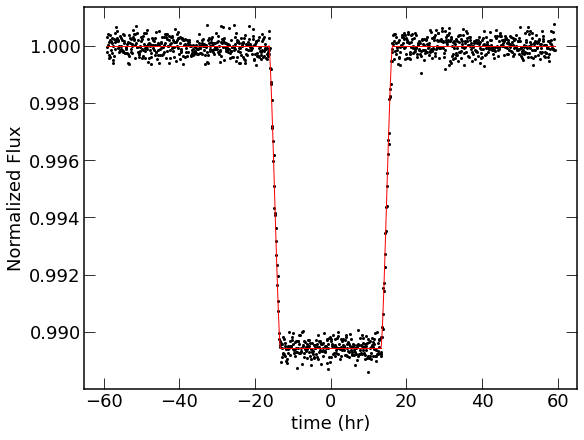

In [ ]:
fig, ax = plt.subplots(figsize=(8,6), constrained_layout=True)
#ax.errorbar(phi, RV_sim.value, yerr=yerr, color='k', fmt='.', markersize=4, elinewidth=1, capsize=2)
ax.plot(out_time, out_trans_sim, '.k', markersize=4)
#ax.errorbar(out_time, out_trans_sim, yerr=[0.001 for i in out_time], color='k', fmt='.', markersize=4, elinewidth=1, capsize=2)
ax.plot(in_time, in_trans_sim, '.k', markersize=4)
ax.plot(t_ingress, ingress_sim, '.k', markersize=4)
ax.plot(t_egress, egress_sim, '.k', markersize=4)
ax.plot(out1_time, out_trans1_true, 'r', linewidth=1)
ax.plot(t_ingress, ingress, 'r', linewidth=1)
ax.plot(t_egress, egress, 'r', linewidth=1)
#ax.vlines(-t_transit.value, in_trans_true[0], out_trans_true[0], 'r')
#ax.vlines(t_transit.value, in_trans_true[0], out_trans_true[0], 'r')
ax.plot(out2_time, out_trans2_true, 'r', linewidth=1)
ax.plot(in_time, in_trans_true, 'r', linewidth=1)
ax.set_ylabel("Normalized Flux")
ax.set_xlabel("time (hr)")
#ax.set_xlim(phi[0], phi[-1])
#fig.savefig("transit-signal-plot.jpg")
plt.show()

## Direct Imaging

In [ ]:
#Albedo of Jupiter
Alb = 0.503

The fraction of incident starlight reflected at any wavelength (from the Week 2 PowerPoint).
$$
f_{reflect} = \frac{\pi R_J^2}{4 \pi a_J^2} A
$$

where $A$ is the albedo of the planet. [source for Jupiter albedo](https://www.nature.com/articles/s41467-018-06107-2#:~:text=The%20resulting%20Bond%20albedo%20of,a%20value%200.343%20%C2%B1%200.032)

In [ ]:
#fraction of incident starlight reflected
f_reflect = (np.pi * R_J**2 * Alb / (4*np.pi*a_J**2)).decompose()
print("The fraction of incident starlight reflected: f =", f_reflect)

The fraction of incident starlight reflected: f = 1.0609162594433823e-09


The ratio of thermal emission of the planet to the star, using the Plank function (see the PowerPoint). I need the temperatures of both Jupiter and the Sun. [source for Jupiter temperature.](https://solarsystem.nasa.gov/resources/681/solar-system-temperatures/) I wrote a function to do this for a given wavelength.

In [ ]:
def find_f_emit(lamb):
    #effective temp of Sun
    T_sun = 5775 * u.K
    #equilibrium temp of Jupiter
    T_J = (-110 + 273.15) * u.K
    #wavelength of light we observe emission at / convert to frequency
    nu = ac.c / lamb
    #ratio of emission (Jupiter/Sun)
    f_emit = ((R_J/ac.R_sun)**2 * (m.exp((ac.h * nu / ac.k_B / T_sun).value) - 1) / (m.exp((ac.h * nu / ac.k_B / T_J).value) - 1)).decompose()
    return f_emit

Calculate ratio at a certain wavelength.

In [ ]:
test_lamb = 3.8e-6 * u.m
print("The planet-star ratio of thermal emission: f =", find_f_emit(test_lamb))

The planet-star ratio of thermal emission: f = 8.159955477971073e-13


In [ ]:
#Gemini Planet Imager on the Gemini South Telescope (diameter)
Diam = 8.1 * u.m

#Using the same wavelength as above, find the distance the planetary system it can be and still be discoverable
d = (a_J * Diam / 1.22 / test_lamb).decompose().to(u.pc)
d

<Quantity 44.07191657 pc>

## Astrometry

In [ ]:
#radius of circle star makes
a_star = ((M_J/M_sun) * a_J).decompose()
print(a_star)
a_star/ac.R_sun

743001512.1462792 m


<Quantity 1.06799125>

The star wobbles in a circle with the radius approximately equal to the radius of the star.

In [ ]:
#GRAVITY, on the The Very Large Telescope Interferometer is the state-of-the-art (4 x 8.2m telescope)
lamb_as = 2.2e-6 * u.m
as_diam = 200 * u.m
dis = (2 * (M_J/M_sun) * a_J / 1.22 / (lamb_as/as_diam)).decompose().to(u.pc)
dis

<Quantity 3.58853042 pc>

In [ ]:
dis2 = 10 * u.pc
as_diam2 = (1.22 * lamb_as / 2 / (a_J/dis2) / (M_J/M_sun)).decompose()
as_diam2

<Quantity 557.33120952 m>